# BPS (Batch Processing Service) notebook

https://pipelines.lsst.io/v/weekly/modules/lsst.ctrl.bps/quickstart.html#bps-configuration-file

## Yaml file

These files contain all the configurations to run the PTC objects and cpCovariances for all CCDs using BPS. The configuration file used to generate the "bps_ALLCCD_20220701" collection is shown below.

### BPS_file.yaml

### cpPtc.yaml

This file is used by *BPS_file.yaml*

## For running
*bps submit bps_file_name.yaml*

## For checking the status
*bps report --hist 0.2 --user USERNAME*  or   *bps report --id id_number*

## For knowing the version that has been run
*eups list -s lsst_distrib*

## In case of the next error
<font color='red'>  **ImportError:** Could not get attribute 'HTCondorService' from 'lsst.ctrl.bps.htcondor' when importing 'lsst.ctrl.bps.htcondor.HTCondorService' (No module named 'lsst.ctrl.bps.htcondor.HTCondorService')</font>

*export PYTHONPATH=$PYTHONPATH:/usr/lib64/python3.6/site-packages*


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay

# Function for obtain gain, flux, read-out noise and amplifier names from cpCovariances objetc

cpCovariances objetc calculates gain, flux, read noise and other parameters for flat pairs. Then, it there are 338 flat pairs, it calculates 338 of these values for each amplifier. 

In [2]:
def gain_flux_noise_cpCovariances(CCD, butlerx):  
    """
    Extract gain, flux, read-out noise and amplifier names from cpCovariances object
    
    Parameters
    ----------
    CCD: int, number of the CCD for LSSTCam
    butlerx: str, name of the butler with which you loaded the collection to use
    
    
    Return
    ------
    Returns a multidimensional array for gain, flux, read-out noise, and one-dimensional 
    array for amplifier names.
    
    - Multidimensional array has nrows: number of flat pairs used, ncols: number of amplifiers
    
    For 16 amplifiers and 9 flat pairs
    
    |amp1   amp2  amp3 ... amp16|
    |gain1 gain1 gain1 ... gain1|
    |gain2 gain2 gain2 ... gain2|
    |            ...            |
    |gain9 gain9 gain9 ... gain9|
    
    """
    gain = []
    flux = []
    rd_noise = []

    for i in exposure_first:
        cp = butlerx.get("cpCovariances", instrument="LSSTCam", detector=CCD, exposure= i)
        gain += [np.array(list(cp.gain.values()))]
        flux += [np.array(list(cp.rawMeans.values()))]
        rd_noise += [np.array(list(cp.noise.values()))]
    return np.array(gain), np.array(flux), np.array(rd_noise), np.array(list(cp.ampNames))

# For plots

In [3]:
color_list = cm.get_cmap('plasma', 16) ##Lista de colores
shapes_list = [".", '+',"o", "v", "x", 's', '*', 'd', '|', '>', '1', 'p','<', '2', '^', '4']

# Loading collection: software version "w_2022_27"

This collection was generated using the software version "w_2022_27".
This code uses *afwMath.MEANCLIP* for the calculation of $\frac{1}{g} = \big \langle \frac{(I_1 - I_2)^2}{I_1 + I_2}\big  \rangle$, where $I_1$ is the first flat and $I_2$ is the second flat of the pair at the same exposure time, and $g$ is the gain.

In [4]:
genCollection = "u/lgiraldo/bps_ALLCCD_20220701"#"u/lgiraldo/bps_test10"
butler = dB.Butler("/repo/main/", collections=genCollection)

## PTC object for detector 55

In [5]:
CCD = 55
ptcDataset55 = butler.get("ptc", instrument="LSSTCam", detector=CCD)

## Obtaining the gain, read-out noise, and turnoff from PTC object

In [6]:
gain_ptc55 = np.array(list(ptcDataset55.gain.values()))
rd_noise_ptc55 = np.array(list(ptcDataset55.noise.values()))
turnoff55 = np.array(list(ptcDataset55.ptcTurnoff.values()))  ##Related to the Full Well Capacity

## Exposure pairs
The PTC was constructed by pairs of exposures, which means, pair of flats with different exposure times. These are the identifiers of the images.

In [7]:
## Exposure pairs
exposure_pairs = np.array(sorted(ptcDataset55.inputExpIdPairs['C00']))

##First exposure of the pair
exposure_first = exposure_pairs[:,0][:,0]

## Using the function

In [8]:
gain, flux, rd_noise, amp_names = gain_flux_noise_cpCovariances(CCD, butler)

## Plot: Percentage relative error in gain and Read out noise

This plot shows the percentage difference between the PTC gain (unique) with each of those obtained with cpCovariances

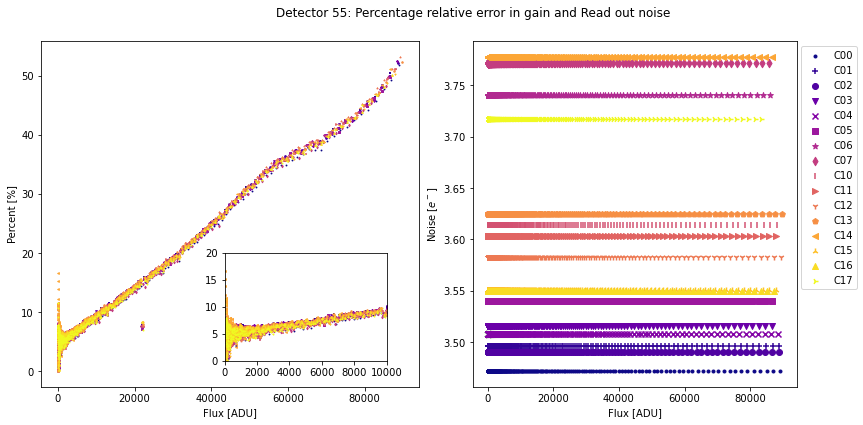

In [10]:
turn_off_indx = []
gain_ptc = gain_ptc55
turnoff = turnoff55

fig = plt.figure(figsize=(15,6))
axes = fig.add_axes([0.1,0.1,0.35,0.8]) # eje principal
axes2 = fig.add_axes([0.27,0.16,0.15,0.25]) # eje interior
axes3 = fig.add_axes([0.5,0.1,0.3,0.8]) # eje interior
fig.suptitle(f'Detector {CCD}: Percentage relative error in gain and Read out noise')
for k in range(len(gain[1,:])):
    relative = abs(gain[:,k] - gain_ptc[k])/gain_ptc[k] * 100
    turnoff_index = np.where(flux[:,k] < turnoff[k])[0]
    turn_off_indx.append(turnoff_index)

    axes.scatter(flux[turnoff_index,k], relative[turnoff_index], color = color_list(k), s=3, marker = shapes_list[k] ,label=amp_names[k])#, '.')
    axes2.scatter(flux[turnoff_index,k], relative[turnoff_index], color = color_list(k), s=3, marker = shapes_list[k] ,label=amp_names[k])#, '.')
    axes3.scatter(flux[turnoff_index,k], rd_noise[turnoff_index,k], color = color_list(k),marker = shapes_list[k] ,label=amp_names[k])
    axes2.set_xlim(0, 10000)
    axes2.set_ylim(0,20)
#      
    axes.set_xlabel('Flux [ADU]')
    axes.set_ylabel('Percent [%]')
    axes3.set_xlabel('Flux [ADU]')
    axes3.set_ylabel(r'Noise [$e^-$]')

    axes3.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Loading collection: software version "w_2022_32"

This collection was generated using the software version  "g0b29ad24fb+cafeaf151e current w_2022_32 setup".
This code uses *afwMath.MEAN* instead *afwMath.MEANCLIP* for the calculation of $\frac{1}{g} =  \big \langle \frac{(I_1 - I_2)^2}{I_1 + I_2}\big  \rangle$, where $I_1$ is the first flat and $I_2$ is the second flat of the pair at the same exposure time, and $g$ is the gain.

The image below shows the old code in red and the new code in green.
https://github.com/lsst/cp_pipe/commit/f19206de9363412da5e6ca0695ae1fe00a9b4b79

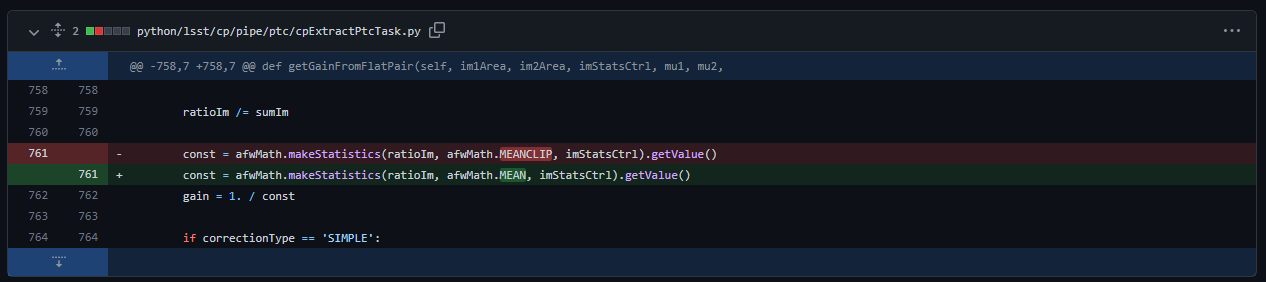

In [4]:
genCollection1 = "u/lgiraldo/bps_ALLCCD_v2_20220804" #bps_CCD55_v2_20220804"
butler1 = dB.Butler("/repo/main/", collections=genCollection1)

CCD = 55
ptcDataset55_mod = butler1.get("ptc", instrument="LSSTCam", detector=CCD)

In [5]:
exposure_pairs = np.array(sorted(ptcDataset55_mod.inputExpIdPairs['C00']))
exposure_first = exposure_pairs[:,0][:,0]

In [11]:
gain, flux, noise, amp_names = gain_flux_noise_cpCovariances(CCD, butler1)

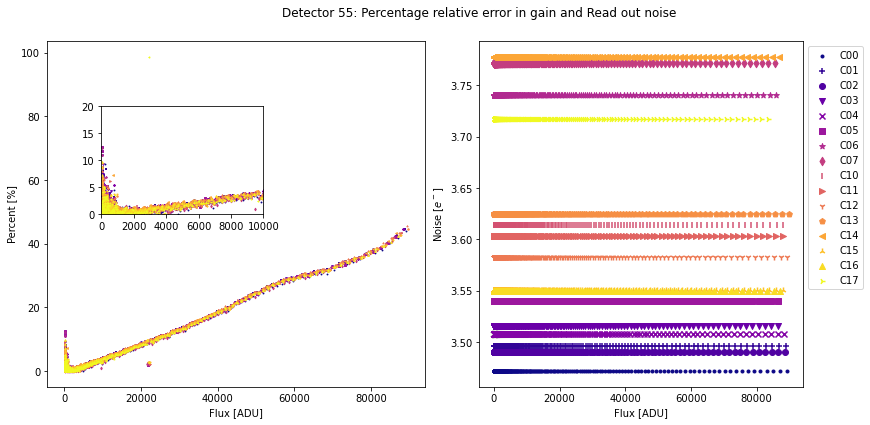

In [12]:
turn_off_indx = []
gain_ptc = np.array(list(ptcDataset55_mod.gain.values()))
turnoff = np.array(list(ptcDataset55_mod.ptcTurnoff.values()))
rd_noise= noise

fig = plt.figure(figsize=(15,6))
axes = fig.add_axes([0.1,0.1,0.35,0.8]) # eje principal
axes2 = fig.add_axes([0.15,0.5,0.15,0.25]) # eje interior
axes3 = fig.add_axes([0.5,0.1,0.3,0.8]) # eje interior
fig.suptitle(f'Detector {CCD}: Percentage relative error in gain and Read out noise')
for k in range(len(gain[1,:])):
    relative = abs(gain[:,k] - gain_ptc[k])/gain_ptc[k] * 100
    turnoff_index = np.where(flux[:,k] < turnoff[k])[0]
    turn_off_indx.append(turnoff_index)

    axes.scatter(flux[turnoff_index,k], relative[turnoff_index], color = color_list(k), s=3, marker = shapes_list[k] ,label=amp_names[k])#, '.')
    axes2.scatter(flux[turnoff_index,k], relative[turnoff_index], color = color_list(k), s=3, marker = shapes_list[k] ,label=amp_names[k])#, '.')
    axes3.scatter(flux[turnoff_index,k], rd_noise[turnoff_index,k], color = color_list(k),marker = shapes_list[k] ,label=amp_names[k])
    axes2.set_xlim(0, 10000)
    axes2.set_ylim(0,20)
#      
    axes.set_xlabel('Flux [ADU]')
    axes.set_ylabel('Percent [%]')
    axes3.set_xlabel('Flux [ADU]')
    axes3.set_ylabel(r'Noise [$e^-$]')

    axes3.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# PTC plot

In [5]:
camera = butler1.get("camera", instrument="LSSTCam")

det_name_to_id = {}  ##From name to number
det_id_to_name = {}  ##From number to name

for det in camera:
    #print(det.getName(), det.getId())
    detName, detId = det.getName(), det.getId()
    if detId < 189:
        det_name_to_id[detName] = detId
        det_id_to_name[detId] = detName

detector_id = det_id_to_name[CCD]
raft55, sensor55 = detector_id.split("_")
print(f"The name of the detector {CCD} is {detector_id}, i.e. it is located in the raft {raft55} and is sensor {sensor55}")

The name of the detector 55 is R13_S01, i.e. it is located in the raft R13 and is sensor S01


The code below was made by Professor Craig Lage, and copied from https://github.com/craiglagegit/ScratchStuff/blob/master/reca/PTC_Curve_Pickle_13144M_03Jun22.ipynb

In [6]:
def getDetector(raft, sensor):
    # Subroutine to find vendor and detector number given raft and sensor                                                                                                                                                           
    startingCol = [1,0,0,0,1] # First raft column in each row                                                                                                                                                                       
    rows = [0,3,8,13,18] # Starting raft sequence number of each row                                                                                                                                                                
    if raft in ['R11','R12','R13','R14','R21','R22','R23','R24','R30',\
                'R31','R32','R33','R34']:
        vendor = 'E2V'
    else:
        vendor = 'ITL'
    raftRow = int(list(raft)[1])
    raftCol = int(list(raft)[2])
    sensorRow = int(list(sensor)[1])
    sensorCol = int(list(sensor)[2])
    detectorNum = (rows[raftRow] + (raftCol - startingCol[raftRow])) * 9
    detectorNum += 3 * sensorRow + sensorCol
    return vendor, detectorNum


def ExpApprox(mu, g, a00, n):
    # This is the equation for the ExpApprox for use in the notebook
    if (g < 1.0E-6) or (abs(a00) < 1.0E-9):
        return np.zeros([len(mu)])
    else:
        expFactor = 2.0 * a00 * mu * g
        if max(expFactor) > 100.0:
            return np.zeros([len(mu)])
        else:
            preFactor = 1.0 / (2.0 * g * g * a00)
            noiseTerm = n / (g * g)
            return preFactor * (np.exp(expFactor) - 1.0) + noiseTerm

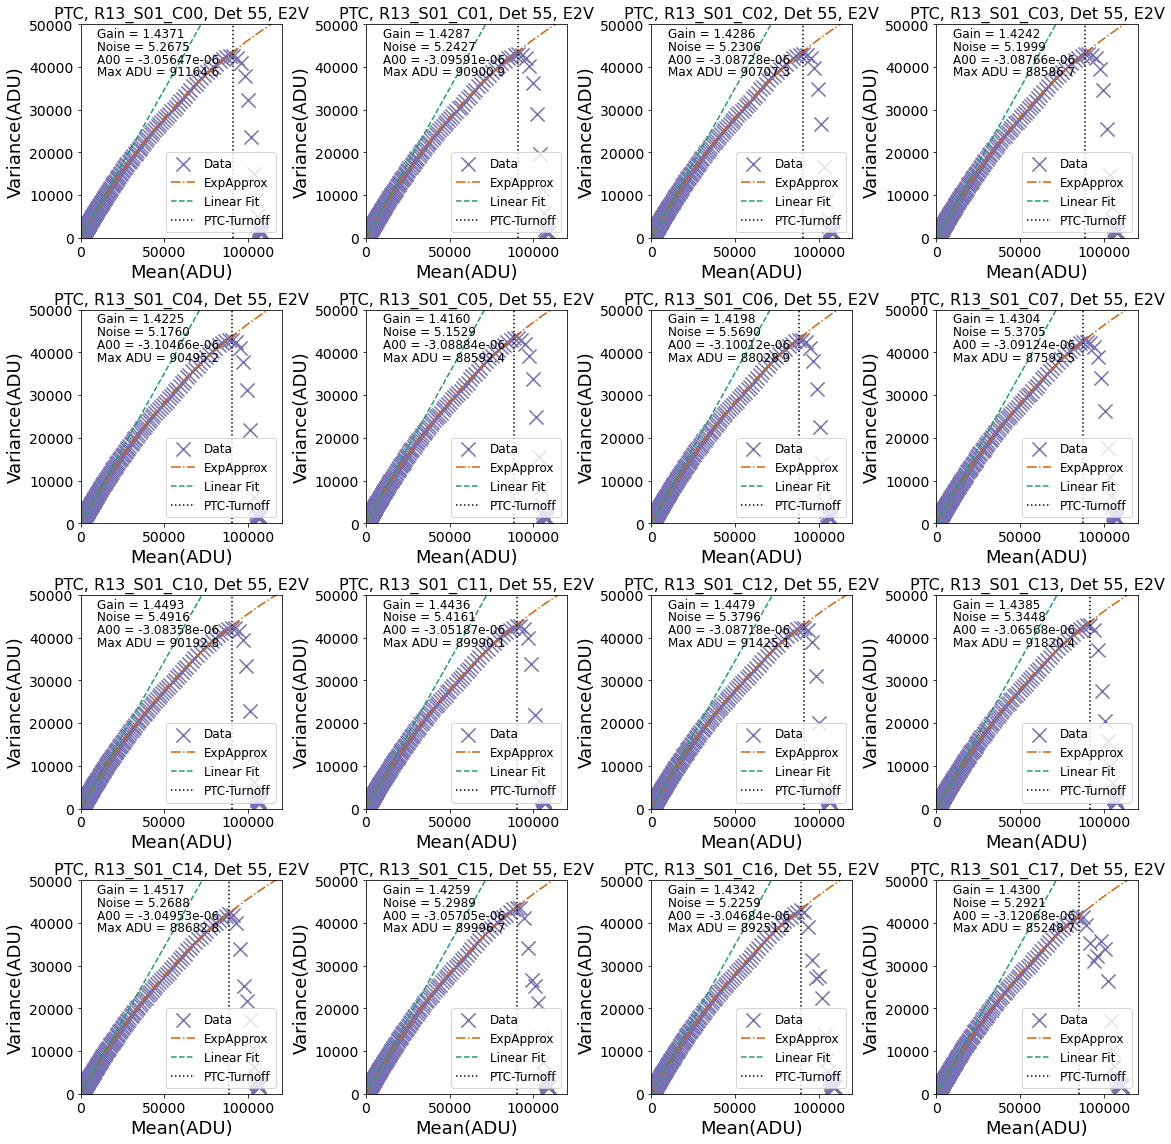

In [16]:
fig, axes = plt.subplots(4,4,figsize=(16,16))
count = 0

for i in range(4):
    for j in range(4):
        axes[i,j].scatter(0,0)
        amp = amp_names[count]
        VENDOR, DETECTOR  = getDetector(raft55, sensor55)
        
        ptcDataset = butler1.get('ptc', detector=DETECTOR, instrument='LSSTCam')
        dmGain = ptcDataset.gain[amp]
        if ptcDataset.ptcFitType == 'EXPAPPROXIMATION':
            dmA00 = ptcDataset.ptcFitPars[amp][0]
        if ptcDataset.ptcFitType == 'FULLCOVARIANCE':
            dmA00 = ptcDataset.aMatrix[amp][0][0]
        dmNoise = ptcDataset.noise[amp]
        rawMeans = ptcDataset.rawMeans[amp]
        rawVars = ptcDataset.rawVars[amp]
        dmMeans = np.array(ptcDataset.finalMeans[amp])
        dmMeans = dmMeans[~np.isnan(dmMeans)]
        turnoff = ptcDataset.ptcTurnoff[amp]
        if len(dmMeans > 0):
            maxDM = dmMeans.max()
        else:
            maxDM = 0.0

        axes[i,j].set_title(f"PTC, {raft55}_{sensor55}_{amp}, Det {DETECTOR}, {VENDOR}", fontsize = 16)
        axes[i,j].scatter(rawMeans, rawVars, marker = 'x', s=200, color = '#7570b3', label = 'Data')

        axes[i,j].text(10000,47000,f"Gain = {dmGain:.4f}", fontsize=12)
        axes[i,j].text(10000,44000,f"Noise = {dmNoise:.4f}", fontsize=12)
        axes[i,j].text(10000,41000,f"A00 = {dmA00:.6g}", fontsize=12)
        axes[i,j].text(10000,38000,f"Max ADU = {turnoff:.1f}", fontsize=12)
        xplot = np.linspace(0.0, 120000, 200)
        yplot = ExpApprox(xplot,dmGain,dmA00,dmNoise)
        linyplot = xplot * 1/dmGain
        
        axes[i,j].plot(xplot, yplot, ls = '-.', color = '#d95f02', label = "ExpApprox")
        axes[i,j].plot(xplot, linyplot, ls = '--', color = '#1b9e77', label = "Linear Fit")
        axes[i,j].axvline(turnoff, ls = ':', color = 'black', label = "PTC-Turnoff")
        axes[i,j].set_xlabel("Mean(ADU)", fontsize=18)
        axes[i,j].set_ylabel("Variance(ADU)", fontsize=18)
        axes[i,j].set_xlim(0,120000)
        axes[i,j].set_ylim(0,50000)
        axes[i,j].legend(fontsize = 12)
        axes[i,j].tick_params(labelsize=14)
        count +=1
fig.tight_layout()
fig.savefig(f'./FocalPlane_plots/PTC_Detector{DETECTOR}.png', dpi=500)

# Generating all the PTC plots for the focal plane

In [7]:
ampNames = ['C00', 'C01', 'C02','C03','C04','C05','C06', 'C07', 
           'C10', 'C11', 'C12','C13','C14','C15','C16', 'C17']

for CCD in range(183,189):
    detector_id = det_id_to_name[CCD]
    raft55, sensor55 = detector_id.split("_")


    fig, axes = plt.subplots(4,4,figsize=(16,16))
    count = 0

    for i in range(4):
        for j in range(4):
            axes[i,j].scatter(0,0)
            amp = ampNames[count]
            VENDOR, DETECTOR  = getDetector(raft55, sensor55)

            ptcDataset = butler1.get('ptc', detector=DETECTOR, instrument='LSSTCam')
            dmGain = ptcDataset.gain[amp]
            if ptcDataset.ptcFitType == 'EXPAPPROXIMATION':
                dmA00 = ptcDataset.ptcFitPars[amp][0]
            if ptcDataset.ptcFitType == 'FULLCOVARIANCE':
                dmA00 = ptcDataset.aMatrix[amp][0][0]
            dmNoise = ptcDataset.noise[amp]
            rawMeans = ptcDataset.rawMeans[amp]
            rawVars = ptcDataset.rawVars[amp]
            dmMeans = np.array(ptcDataset.finalMeans[amp])
            dmMeans = dmMeans[~np.isnan(dmMeans)]
            turnoff = ptcDataset.ptcTurnoff[amp]
            if len(dmMeans > 0):
                maxDM = dmMeans.max()
            else:
                maxDM = 0.0

            axes[i,j].set_title(f"PTC, {raft55}_{sensor55}_{amp}, Det {DETECTOR}, {VENDOR}", fontsize = 16)
            axes[i,j].scatter(rawMeans, rawVars, marker = 'x', s=200, color = '#7570b3', label = 'Data')

            axes[i,j].text(10000,47000,f"Gain = {dmGain:.4f}", fontsize=12)
            axes[i,j].text(10000,44000,f"Noise = {dmNoise:.4f}", fontsize=12)
            axes[i,j].text(10000,41000,f"A00 = {dmA00:.6g}", fontsize=12)
            axes[i,j].text(10000,38000,f"Turnoff = {turnoff:.1f}", fontsize=12)
            xplot = np.linspace(0.0, 120000, 200)
            
            yplot = ExpApprox(xplot,dmGain,dmA00,dmNoise)
            linyplot = xplot * 1/dmGain
            axes[i,j].plot(xplot, yplot, ls = '--', color = '#d95f02', label = "ExpApprox")
            axes[i,j].plot(xplot, linyplot, ls = '--', color = '#1b9e77', label = "Linear Fit")
            axes[i,j].axvline(turnoff, ls = ':', color = 'black', label = "PTC-Turnoff")
            axes[i,j].set_xlabel("Mean(ADU)", fontsize=18)
            axes[i,j].set_ylabel("Variance(ADU)", fontsize=18)
            axes[i,j].set_xlim(0,120000)
            axes[i,j].set_ylim(0,50000)
            axes[i,j].legend(fontsize = 12)
            count +=1
            axes[i,j].tick_params(labelsize=14)
    fig.tight_layout()
    fig.savefig(f'./PTC_plots//PTC_Detector{DETECTOR}.png', dpi=500)
    plt.close(fig)

In [21]:
def var_mean(butler, raft, sensor):
    
    fig, axes = plt.subplots(4,4,figsize=(16,16))
    ##Count for amplifiers
    count = 0

    for i in range(4):
        for j in range(4):
            ##Selecting the amplifier
            amp = ampNames[count]
            VENDOR, DETECTOR  = getDetector(raft, sensor)

            ptcDataset = butler.get('ptc', detector=DETECTOR, instrument='LSSTCam')
           
            rawMeans = ptcDataset.rawMeans[amp]
            rawVars = ptcDataset.rawVars[amp]
            VarMean = np.array(rawVars)/np.array(rawMeans)
        
        
            axes[i,j].set_title(f"{raft}_{sensor}_{amp}, Det {DETECTOR}, {VENDOR}", fontsize = 14)
            axes[i,j].scatter(rawMeans, VarMean, marker = '.', s=50, color = '#7570b3', zorder=2)
            
            GAIN = ptcDataset.gain[amp]
            NOISE = ptcDataset.noise[amp]
            TURNOFF = ptcDataset.ptcTurnoff[amp]
            
            axes[i,j].scatter([],[], s = 0.001, label = f'$Gain =${GAIN:.2f}')
            axes[i,j].scatter([],[], s = 0.001, label = f'$Noise =${NOISE:.2f}')
            if ptcDataset.ptcFitType == 'EXPAPPROXIMATION':
                A00 = ptcDataset.ptcFitPars[amp][0]
                axes[i,j].scatter([],[], s = 0.001, label = r'$a_{00} =$'+f'{A00:.2e}')
            if ptcDataset.ptcFitType == 'FULLCOVARIANCE':
                A00 = ptcDataset.aMatrix[amp][0][0]
                axes[i,j].scatter([],[], s = 0.001, label = r'$a_{00} =$'+f'{A00:.2e}')
            #axes[i,j].scatter([],[], s = 0.001, label = f'$\Turnoff =${TURNOFF:.4f} %')
        

            axes[i,j].set_xlabel("Mean  (ADU)", fontsize=14)
            axes[i,j].set_ylabel("Variance / Mean", fontsize=14)
            axes[i,j].set_xlim(0,120000)
            axes[i,j].axvline(ptcDataset.ptcTurnoff[amp], ls='--', color='black', label = f'$Turnoff =${TURNOFF:.2f}')
            #axes[i,j].set_ylim(0,50000)
            xtick_loc = [0, 20000, 40000, 60000, 60000, 80000, 100000]
            axes[i,j].set_xticks(xtick_loc);
            if DETECTOR == 139:
                axes[i,j].legend(fontsize = 12, frameon=False, loc = 'lower left')
            else:
                axes[i,j].legend(fontsize = 12, frameon=False, loc = 'upper left')
            count +=1
    fig.tight_layout()

    fig.savefig(f'./Var_Mean_Plots/Var_Mean_{DETECTOR}.png')
    plt.close(fig)

In [23]:
ampNames = ['C00', 'C01', 'C02','C03','C04','C05','C06', 'C07', 
           'C10', 'C11', 'C12','C13','C14','C15','C16', 'C17']
for CCD in range(2,189):
    detector_id = det_id_to_name[CCD]
    raft55, sensor55 = detector_id.split("_")
    var_mean(butler1, raft55, sensor55)

# PTCs with low turnoff

In [24]:
## [Detector, amplifier]

low_ptc_turnoff = np.array([[15, 'C17'], [22, 'C00'],  [31, 'C10'],  [72, 'C17'],  [73, 'C00'],  
                           [77, 'C00'],  [117, 'C10'],  [168, 'C16'],  [168, 'C17'],  [169, 'C02'],  
                           [169, 'C11'],  [169, 'C15'],  [170, 'C10'],  [171, 'C17'],  [183, 'C17'],  
                           [188, 'C01'],  [188, 'C02'],  [188, 'C03'],  [188, 'C04']])

In [35]:
for det, amp in low_ptc_turnoff:
    fig, axes = plt.subplots()#figsize=(16,16))
    axes.scatter(0,0)
    detector_id = det_id_to_name[int(det)]
    raft55, sensor55 = detector_id.split("_")
    VENDOR, DETECTOR  = getDetector(raft55, sensor55)

    ptcDataset = butler1.get('ptc', detector=DETECTOR, instrument='LSSTCam')
    dmGain = ptcDataset.gain[amp]
    if ptcDataset.ptcFitType == 'EXPAPPROXIMATION':
        dmA00 = ptcDataset.ptcFitPars[amp][0]
    if ptcDataset.ptcFitType == 'FULLCOVARIANCE':
        dmA00 = ptcDataset.aMatrix[amp][0][0]
    dmNoise = ptcDataset.noise[amp]
    rawMeans = ptcDataset.rawMeans[amp]
    rawVars = ptcDataset.rawVars[amp]
    dmMeans = np.array(ptcDataset.finalMeans[amp])
    dmMeans = dmMeans[~np.isnan(dmMeans)]
    turnoff = ptcDataset.ptcTurnoff[amp]
    
    axes.set_title(f"PTC, {raft55}_{sensor55}_{amp}, Det {DETECTOR}, {VENDOR}", fontsize = 14)
    axes.scatter(rawMeans, rawVars, marker = 'x', s=200, color = '#7570b3', label = 'Data')

    axes.text(10000,47000,f"Gain = {dmGain:.4f}", fontsize=12)
    axes.text(10000,44000,f"Noise = {dmNoise:.4f}", fontsize=12)
    axes.text(10000,41000,f"A00 = {dmA00:.6g}", fontsize=12)
    axes.text(10000,38000,f"Turnoff = {turnoff:.1f}", fontsize=12)
    xplot = np.linspace(0.0, 120000, 200)
    
    yplot = ExpApprox(xplot,dmGain,dmA00,dmNoise)
    linyplot = xplot * 1/dmGain
    axes.plot(xplot, yplot, ls = '--', color = '#d95f02', label = "ExpApprox")
    axes.plot(xplot, linyplot, ls = '--', color = '#1b9e77', label = "Linear Fit")
    axes.axvline(turnoff, ls = ':', color = 'black', label = "PTC-Turnoff")
    axes.set_xlabel("Mean(ADU)", fontsize=14)
    axes.set_ylabel("Variance(ADU)", fontsize=14)
    axes.set_xlim(0,120000)
    axes.set_ylim(0,50000)
    axes.legend(fontsize = 12, loc = 'center right')
    
    fig.savefig(f'./PTC_plots/Low_PTC_Turnoff/PTC_Detector{DETECTOR}_{amp}.png', dpi=500, bbox_inches='tight')
    plt.close(fig)

15
22
31
72


/tmp/ipykernel_46800/746795636.py:32: RuntimeWarning: divide by zero encountered in true_divide
  linyplot = xplot * 1/dmGain
/tmp/ipykernel_46800/746795636.py:32: RuntimeWarning: invalid value encountered in true_divide
  linyplot = xplot * 1/dmGain


73
77
117


/tmp/ipykernel_46800/746795636.py:32: RuntimeWarning: divide by zero encountered in true_divide
  linyplot = xplot * 1/dmGain
/tmp/ipykernel_46800/746795636.py:32: RuntimeWarning: invalid value encountered in true_divide
  linyplot = xplot * 1/dmGain


168
168
169
169
169
170
171
183
188
188
188
188
